# Final Project 1

In [1]:
import pandas as pd

import numpy as np
import pandas as pd
import cvxpy as cp
import gurobipy

import os

In [2]:
GW_wind = 12
RGGI = True
PTC = False
carbontax = False
output_directory = str(GW_wind) + 'GW'
if RGGI:
    output_directory = output_directory + "_RGGI"
if PTC:
    output_directory = output_directory + "_PTC"
if carbontax:
    output_directory = output_directory + "_Scenario_4"
output_directory

'12GW_RGGI'

In [3]:
# Check if the directory exists; if not, create it
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    print(f"Directory '{output_directory}' created.")
else:
    print(f"Directory '{output_directory}' already exists.")


# Print the installed solver to see if GUROBI is installed correctly
print("Current installed solvers: ", cp.installed_solvers())


generator_data = pd.read_csv(r'https://github.com/luko12/iso-ne-unit-commitment-optimization/raw/refs/heads/main/generator_data-2.csv')
demand_data = pd.read_csv(r'https://github.com/luko12/iso-ne-unit-commitment-optimization/raw/refs/heads/main/wind_and_demand.csv')

generator_data['Zone \nLocation'] = generator_data['Zone \nLocation'].apply(
    lambda x: 'MASS' if 'MASS' in x else x
)
#ADDITIONAL DATA
Fuel_Heating_Values = pd.read_csv('Fuel_Heating_Values.csv')
CO2_Allowances = pd.read_csv('CO2_Allowances.csv')
Net_Gen_Emissions = pd.read_csv('Net_Gen_Emissions.csv')
Fuel_Type_Mapping = pd.read_csv('Fuel_Type_Mapping.csv')

# Rename 'Fuel Type' to 'Energy Type' in Fuel_Type_Mapping
Fuel_Type_Mapping.rename(columns={'Fuel Type': 'Energy Type'}, inplace=True)

# Rename 'Fuel Type' to 'Energy Type' in Fuel_Heating_Values
Fuel_Heating_Values.rename(columns={'Fuel Type': 'Energy Type'}, inplace=True)

# Rename 'Fuel Type' to 'Energy Type' in Net_Gen_Emissions
Net_Gen_Emissions.rename(columns={'Fuel Type': 'Energy Type'}, inplace=True)

Net_Gen_Emissions["Short Tons per KWH"] = Net_Gen_Emissions["CO2 Emissions (pounds per kWh)"] / 2000

Net_Gen_Emissions["Short Tons per MWH"] = Net_Gen_Emissions["Short Tons per KWH"] * 1000


# Step 1: Clean fuel type data in `generator_data`
generator_data['Fuel Type Cleaned'] = generator_data['Fuel Type'].str.strip()

# Step 2: Map Generator Fuel Types to Energy Source Codes
def map_fuel_to_code(fuel_type):
    fuel_type = fuel_type.strip()
    if fuel_type in ['BIT', 'SUB']:  # Examples of Coal types
        return 'BIT' if fuel_type == 'BIT' else 'SUB'
    elif fuel_type == 'RFO':  # Residual Fuel Oil
        return 'RFO'
    elif fuel_type.startswith('NG'):  # General Natural Gas
        return 'NG'
    elif fuel_type == 'NUC':  # Nuclear
        return 'NUC'
    elif fuel_type.startswith('NGT'):  # Natural Gas Turbine
        return 'NG'
    else:
        return 'OTH'  # Default to 'Other' for unrecognized types

# Add mapped Energy Source Code to `generator_data`
generator_data['Energy Source Code'] = generator_data['Fuel Type Cleaned'].apply(map_fuel_to_code)

# Step 3: Lookup Energy Type from `Fuel_Type_Mapping`
# Merge generator data with Fuel_Type_Mapping based on Energy Source Code
generator_data = generator_data.merge(
    Fuel_Type_Mapping[['Energy Source Code', 'Energy Type']],
    on='Energy Source Code',
    how='left'
)

# Step 4: Lookup Heating Values and CO2 Emissions
# Merge with `Fuel_Heating_Values` to get MMBtu Lower and Upper
# Initialize empty lists to store MMBtu Lower and MMBtu Upper values for each generator
mmbtu_lower_values = []
mmbtu_upper_values = []

# Iterate through each row in generator_data
for index, row in generator_data.iterrows():
    # Get the Energy Type for the current generator
    energy_type = row['Energy Type']
    if energy_type == 'Natural Gas and Other Gases':
        energy_type = 'Natural Gas'
    if energy_type == 'All Other Fuels':
        energy_type = 'Other Fuels'
    if energy_type == 'Petroleum Products':
        energy_type = 'Petroleum'
    
    # Filter Fuel_Heating_Values to find the matching Energy Type
    matching_row = Fuel_Heating_Values[Fuel_Heating_Values['Energy Type'] == energy_type]
    
    if not matching_row.empty:
        # Add the corresponding MMBtu Lower and MMBtu Upper values
        mmbtu_lower_values.append(matching_row['MMBtu Lower'].values[0])
        mmbtu_upper_values.append(matching_row['MMBtu Upper'].values[0])
    else:
        # If no match is found, add NaN values
        mmbtu_lower_values.append(None)
        mmbtu_upper_values.append(None)

# Add the MMBtu Lower and MMBtu Upper values to generator_data
generator_data['MMBtu Lower'] = mmbtu_lower_values
generator_data['MMBtu Upper'] = mmbtu_upper_values

# Debug: Check if the columns were added
if 'MMBtu Lower' in generator_data.columns and 'MMBtu Upper' in generator_data.columns:
    print("MMBtu Lower and MMBtu Upper successfully added to generator_data!")
else:
    print("Error: Failed to add MMBtu Lower and MMBtu Upper to generator_data.")


# Initialize an empty list to store CO2 Emissions (pounds per kWh) for each generator
co2_emissions_values = []

# Iterate through each row in generator_data
for index, row in generator_data.iterrows():
    # Get the Energy Type for the current generator
    energy_type = row['Energy Type']
    
    # Custom mappings for specific Energy Types
    if energy_type == 'Natural Gas and Other Gases':
        energy_type = 'Natural gas'
    if energy_type == 'All Other Fuels':
        energy_type = 'All energy sources'
    if energy_type == 'Petroleum Products':
        energy_type = 'Petroleum'
    if energy_type == 'Coal':
        energy_type = 'Coal'
    
    # Filter Net_Gen_Emissions to find the matching Energy Type
    matching_row = Net_Gen_Emissions[Net_Gen_Emissions['Energy Type'] == energy_type]
    
    if not matching_row.empty:
        # Add the corresponding CO2 Emissions (pounds per kWh) value
        co2_emissions_values.append(matching_row['CO2 Emissions (pounds per kWh)'].values[0])
    else:
        # If no match is found, add NaN values
        co2_emissions_values.append(None)

# Add the CO2 Emissions (pounds per kWh) values to generator_data
generator_data['CO2 Emissions (pounds per kWh)'] = co2_emissions_values

# Debug: Check if the column was added
if 'CO2 Emissions (pounds per kWh)' in generator_data.columns:
    print("CO2 Emissions (pounds per kWh) successfully added to generator_data!")
else:
    print("Error: Failed to add CO2 Emissions (pounds per kWh) to generator_data.")


# Get unique Energy Source Codes from generator_data
unique_energy_codes = generator_data['Energy Source Code'].unique()

# Create a dictionary to store indexes for each Energy Source Code
energy_source_indexes = {}

# Find indexes for each unique Energy Source Code
for code in unique_energy_codes:
    indexes = generator_data[generator_data['Energy Source Code'] == code].index.tolist()
    energy_source_indexes[code] = indexes



Directory '12GW_RGGI' already exists.
Current installed solvers:  ['CLARABEL', 'ECOS', 'ECOS_BB', 'GUROBI', 'OSQP', 'SCIPY', 'SCS']
MMBtu Lower and MMBtu Upper successfully added to generator_data!
CO2 Emissions (pounds per kWh) successfully added to generator_data!


In [4]:
# Calculate daily CO2 limits
daily_co2_limits = CO2_Allowances['CO2 Allowance Base Budget'] / 365  # Convert annual to daily

# Map Zone Location to CO2 Allowance
zone_to_state = {
    'NH': 'New Hampshire',
    'CT': 'Connecticut',
    'ME': 'Maine',
    'VT': 'Vermont',
    'RI': 'Rhode Island',
    'MASS': 'Massachusetts'#,
    # 'WCMASS': 'Massachusetts'
}

# Create a mapping of zone to daily CO2 limits
zone_daily_co2_limit = {row['2-Letter Code']: limit
                        for _, row in CO2_Allowances.iterrows()
                        for limit in [row['CO2 Allowance Base Budget'] / 365]}  # Convert annual to daily


In [5]:
#SETUP I

# Problem parameters
N = 76#len(generator_data)  # Number of generators
H = 24  # Number of hours per day
total_days = 7  # Total number of days

#DEC VARS

# Continuous decision variables
g = cp.Variable((N, H), nonneg=True)  # production of generator i during time period t
r = cp.Variable((N, H), nonneg=True)  # hourly reserve generator i could provide during time period t
w = cp.Variable(H, nonneg=True)       # wind power generation during time period t
s = cp.Variable(H, nonneg=True)       # slack variable representing cost of load shedding during time period t

# Binary decision variables
u = cp.Variable((N, H), boolean=True)  # 1 if generator i is on during time period t, otherwise 0
v = cp.Variable((N, H), boolean=True)  # 1 if generator i is turned on at the start of period t, otherwise 0
z = cp.Variable((N, H), boolean=True)  # 1 if generator i is turned off at the start of period t, otherwise 0

#PARAMETERS

# Cost parameters
QC = generator_data['Dispatch Cost Quadratic\nCoefficient b \n($/MW^2h)'].values  # Quadratic generation cost term for generator i (size N)
LC = generator_data['Dispatch Cost Linear\nCoefficient a \n($/MWh)'].values;  # Linear generation cost term for generator i (size N)
NLC = generator_data['NoLoad\nCost ($)'].values;  # No load cost for generator i (size N)
SUC = generator_data['StartUp \nCost ($)'].values;  # Start-up cost for generator i (size N)

# Unit constraints parameters
Gmax = generator_data['Capacity \n(MW)'].values;           # Maximum generation of generator i (size N)
Gmin = generator_data['Minimum generation (MW)'].values;  # Minimum generation of generator i (size N)
Tup = generator_data['MinUp\nTime (hr)'].values;          # Minimum up time of generator i (size N)
Tdn = generator_data['MinDown \nTime (hr)'].values;       # Minimum down time of generator i (size N)
RR = generator_data['Ramp Rate\n(MW/hr)'].values;         # Ramp rate of generator i (size N)
# Initialize SU and SD for Day 1
SU = np.zeros(N, dtype=int)
SD = np.zeros(N, dtype=int)
u0 = np.zeros(N)  # all generators are off at the start

# Demand and renewable parameters
W = GW_wind * 1000  # Installed wind capacity
prefix = output_directory
alpha = demand_data['WindCF'].values; # Wind capacity factor during time period t (size H)
D = demand_data['Demand'].values; # System demand during time period t (size H)

# Slack variable cost per MWh
slack_cost = 9000

# Constants for PTC
ptc_wind = 26  # $/MW for wind
ptc_nuclear = 3  # $/MW for nuclear

# Nuclear generator indexes
nuclear_indexes = [0, 1, 2, 3, 4]

tax_rfo = 40  
tax_bit = 50
tax_sub = 50  
tax_ng = 15

if not PTC and not carbontax:
    objective = cp.Minimize(
        cp.sum(cp.multiply(LC[:, None], g)) +               # Linear generation cost
        cp.sum(cp.multiply(NLC[:, None], u)) +              # No-load cost
        cp.sum(cp.multiply(SUC[:, None], v)) +              # Start-up cost
        slack_cost * cp.sum(s)                              # Cost of load shedding
    )

elif PTC:
    # Modify the objective function to include PTC for wind and nuclear
    objective = cp.Minimize(
        cp.sum(cp.multiply(LC[:, None], g)) +               # Linear generation cost
        cp.sum(cp.multiply(NLC[:, None], u)) +              # No-load cost
        cp.sum(cp.multiply(SUC[:, None], v)) +              # Start-up cost
        slack_cost * cp.sum(s) -                            # Cost of load shedding
        ptc_wind * cp.sum(w) -                              # Wind PTC
        ptc_nuclear * cp.sum(g[nuclear_indexes, :])         # Nuclear PTC
    )
elif carbontax:
    # Modify the objective function to include taxes for types of carbon
    objective = cp.Minimize(
        cp.sum(cp.multiply(LC[:, None], g)) +               # Linear generation cost
        cp.sum(cp.multiply(NLC[:, None], u)) +              # No-load cost
        cp.sum(cp.multiply(SUC[:, None], v)) +              # Start-up cost
        slack_cost * cp.sum(s) +
        tax_rfo * cp.sum(g[energy_source_indexes['RFO'], :]) +
        tax_bit * cp.sum(g[energy_source_indexes['BIT'], :]) +
        tax_sub * cp.sum(g[energy_source_indexes['SUB'], :]) +
        tax_ng * cp.sum(g[energy_source_indexes['NG'], :]) 
    )

nerrrr


In [6]:
#CONSTRAINTS 

# Core constraints (unchanging for all days)
core_constraints = []

# Generation limits (Equation 2)
for i in range(N):
    for t in range(H):
        core_constraints.append(g[i, t] >= Gmin[i] * u[i, t])
        core_constraints.append(g[i, t] <= Gmax[i] * u[i, t])

# Ramp constraints (Equation 3)
for i in range(N):
    for t in range(1, H):
        core_constraints.append(g[i, t] - g[i, t - 1] >= -RR[i] - Gmin[i] * z[i, t])
        core_constraints.append(g[i, t] - g[i, t - 1] <= RR[i] + Gmin[i] * v[i, t])

# Start-up/shut-down logic (Equations 4 and 5)
for i in range(N):
    for t in range(1, H):
        core_constraints.append(v[i, t] - z[i, t] == u[i, t] - u[i, t - 1])
        core_constraints.append(v[i, t] + z[i, t] <= 1)

# Reserve constraints (Equations 14, 15)
# for t in range(H):
#     core_constraints.append(cp.sum(r[:, t]) >= 0.03 * D[t] + 0.05 * w[t])
for i in range(N):
    for t in range(H):
        core_constraints.append(r[i, t] <= Gmax[i] * u[i, t] - g[i, t])
        core_constraints.append(r[i, t] <= RR[i])

In [7]:
# Initialize empty df to hold marginal prices and costs
marginal_prices_df = pd.DataFrame()
costs_df = pd.DataFrame(columns=['Optimal Cost', 'Linear Generation Cost', 'No Load Cost', 'Start Up Cost', 'Load Shedding Cost'])

In [8]:
# Loop over all days
for day in range(1, total_days + 1):
    print(f"Running optimization for Day {day}")

    daily_demand = D[demand_data['Day'] == day]
    daily_alpha = alpha[(day - 1) * H : day * H]
    
    # Create a new constraint list for the current day
    constraints_set_project = []
    constraints_set_project = core_constraints.copy()

    #CARBON CAP CONSTRAINT - DAILY VERSION
    for zone, state in zone_to_state.items():
        # Get state code and daily CO2 limit
        state_code = CO2_Allowances.loc[CO2_Allowances['State'] == state, '2-Letter Code'].values[0]
        daily_limit = zone_daily_co2_limit[state_code]
        # Get generators in this zone
        zone_generators = generator_data[generator_data['Zone \nLocation'].str.contains(zone)]
        zone_indices = zone_generators.index
        total_daily_emissions = 0
        for i in zone_indices:
            # Get the energy type and map to Net_Gen_Emissions
            energy_type = generator_data.loc[i, 'Energy Type']
            if energy_type == "All Other Fuels":
                energy_type = "All energy sources"
            elif energy_type == "Natural Gas and Other Gases":
                energy_type = "Natural gas"
            elif energy_type == "Petroleum Products":
                energy_type = "Petroleum"

            emission_factor_row = Net_Gen_Emissions[Net_Gen_Emissions['Energy Type'] == energy_type]
            if emission_factor_row.empty:
                raise ValueError(f"Emission factor not found for energy type: {energy_type}")
            short_tons_per_mwh = emission_factor_row["Short Tons per MWH"].values[0]  # Convert to short tons per MWh
            if i == 4: #THIS WAS ONLY A PROBLEM IN VERMONT WITH GENERATOR
                min_gen = generator_data.loc[i, 'Minimum generation (MW)']
                # Calculate tomorrow emissions
                tomorrow_emissions = (
                    cp.sum(u[i, max(0, 23 - Tup[i] + 1):24]) * min_gen * short_tons_per_mwh
                )
                M = 1e6
                constraints_set_project.append(tomorrow_emissions <= daily_limit + M * (1 - u[i, 23]))

                # If u[i, 23] == 0, enforce tomorrow_emissions == 0
                constraints_set_project.append(tomorrow_emissions <= M * u[i, 23])


            # Add the generator's contribution to daily emissions
            #print(f"generator {i} is type {energy_type}, short tons per MWH is {short_tons_per_mwh}")
            total_daily_emissions += cp.sum(g[i, :] * short_tons_per_mwh) #for t in range(0, 24)
        # Add the constraint for the total emissions in this state for the day
        constraints_set_project.append(total_daily_emissions <= daily_limit)

    # Add constraints for the first hour of each day
    for i in range(N):  # Loop over all generators

        # Start-up constraint for v
        constraints_set_project.append(v[i, 0] >= u[i, 0] - u0[i])
        # Shut-down constraint for z
        constraints_set_project.append(z[i, 0] >= u0[i] - u[i, 0])

    # Add minimum up-time constraints (Equation 6)
    for i in range(N):
        for t in range(H):
            constraints_set_project.append(
                cp.sum(v[i, max(0, t - Tup[i] + 1):t + 1]) <= u[i, t]
            )

    # Add minimum down-time constraints (Equation 7)
    for i in range(N):
        for t in range(H):
            constraints_set_project.append(
                cp.sum(z[i, max(0, t - Tdn[i] + 1):t + 1]) <= 1 - u[i, t]
            )

    # Add must-stay-on/off constraints (Equations 8 and 9)
    for i in range(N):
        constraints_set_project.append(cp.sum(u[i, :SU[i]]) == SU[i])
        constraints_set_project.append(cp.sum(u[i, :SD[i]]) == 0)

    # Power balance (Equation 12)
    for t in range(H):
        constraints_set_project.append(
            cp.sum(g[:, t]) + w[t] + s[t] == daily_demand[t]
        )

    # Reserve constraints (Equations 13)
    for t in range(H):
        constraints_set_project.append(cp.sum(r[:, t]) >= 0.03 * daily_demand[t] + 0.05 * w[t])

    for t in range(H):
        constraints_set_project.append(w[t] <= daily_alpha[t] * W)
    
    # Add initial conditions (end-of-day states from the previous day)
    if day > 1:

        # Explanation for Constraint 6 (minimum up-time)
        for i in range(N):
            for t in range(H):
                # Compute the range of hours where this constraint applies
                start_time = max(0, t - Tup[i] + 1)

    # Solve the optimization problem
    problem = cp.Problem(objective, constraints_set_project)
    problem.solve(solver=cp.SCIPY, verbose=False)

    # Display results
    print(f"Optimal Cost for Day {day}:", problem.value)

    linear_gen_cost = np.sum(LC[:, None] * g.value)
    no_load_cost = np.sum(NLC[:, None] * u.value)
    start_up_cost = np.sum(SUC[:, None] * v.value)
    load_shedding_cost = slack_cost * np.sum(s.value)
    costs_df.loc[day] = [problem.value, linear_gen_cost, no_load_cost, start_up_cost, load_shedding_cost]

    #print(f"Generator Outputs for Day {day}:\n", g.value)
    #print(f"Wind Generation for Day {day}:\n", w.value)
    #print(f"Slack Variables (Load Shedding) for Day {day}:\n", s.value)
    #print(f"U for Day {day}:\n", u.value)
    # Objective function breakdown    
    
    # Save results to CSV
    pd.DataFrame(u.value).to_csv(f'{prefix}/u_day{day}.csv', index=False, header=[f"Hour_{t}" for t in range(u.value.shape[1])])

    pd.DataFrame(g.value).to_csv(f'{prefix}/gen_day{day}.csv', index=False)
    pd.DataFrame(w.value, columns=["Wind_Generation"]).to_csv(f'{prefix}/wind_gen_day{day}.csv', index=False)
    pd.DataFrame(s.value, columns=["Load_Shedding"]).to_csv(f'{prefix}/slack_day{day}.csv', index=False)

    print('-----------Now calculating marginal prices-----------')

    u_val = u.value
    v_val = v.value
    z_val = z.value

    if not PTC and not carbontax:
        objective2 = cp.Minimize(
            cp.sum(cp.multiply(LC[:, None], g)) +               # Linear generation cost
            cp.sum(cp.multiply(NLC[:, None], u_val)) +              # No-load cost
            cp.sum(cp.multiply(SUC[:, None], v_val)) +              # Start-up cost
            slack_cost * cp.sum(s)                              # Cost of load shedding
        )

    elif PTC:
        # Modify the objective function to include PTC for wind and nuclear
        objective2 = cp.Minimize(
            cp.sum(cp.multiply(LC[:, None], g)) +               # Linear generation cost
            cp.sum(cp.multiply(NLC[:, None], u_val)) +              # No-load cost
            cp.sum(cp.multiply(SUC[:, None], v_val)) +              # Start-up cost
            slack_cost * cp.sum(s) -                            # Cost of load shedding
            ptc_wind * cp.sum(w) -                              # Wind PTC
            ptc_nuclear * cp.sum(g[nuclear_indexes, :])         # Nuclear PTC
        )
    elif carbontax:
        # Modify the objective function to include PTC for wind and nuclear
        objective2 = cp.Minimize(
            cp.sum(cp.multiply(LC[:, None], g)) +               # Linear generation cost
            cp.sum(cp.multiply(NLC[:, None], u_val)) +              # No-load cost
            cp.sum(cp.multiply(SUC[:, None], v_val)) +              # Start-up cost
            slack_cost * cp.sum(s) +
            tax_rfo * cp.sum(g[energy_source_indexes['RFO'], :]) +
            tax_bit * cp.sum(g[energy_source_indexes['BIT'], :]) +
            tax_sub * cp.sum(g[energy_source_indexes['SUB'], :]) +
            tax_ng * cp.sum(g[energy_source_indexes['NG'], :]) 
        )

    # Core constraints (unchanging for all days)
    constraints2 = []

    #CARBON CAP CONSTRAINT - DAILY VERSION
    for zone, state in zone_to_state.items():
        # Get state code and daily CO2 limit
        #print(state, zone)
        state_code = CO2_Allowances.loc[CO2_Allowances['State'] == state, '2-Letter Code'].values[0]
        daily_limit = zone_daily_co2_limit[state_code]
        #print(daily_limit)
        # Get generators in this zone
        zone_generators = generator_data[generator_data['Zone \nLocation'].str.contains(zone)]
        zone_indices = zone_generators.index
        #print(zone_indices)
        total_daily_emissions = 0
        for i in zone_indices:
            # Get the energy type and map to Net_Gen_Emissions
            energy_type = generator_data.loc[i, 'Energy Type']
            if energy_type == "All Other Fuels":
                energy_type = "All energy sources"
            elif energy_type == "Natural Gas and Other Gases":
                energy_type = "Natural gas"
            elif energy_type == "Petroleum Products":
                energy_type = "Petroleum"

            emission_factor_row = Net_Gen_Emissions[Net_Gen_Emissions['Energy Type'] == energy_type]
            if emission_factor_row.empty:
                raise ValueError(f"Emission factor not found for energy type: {energy_type}")
            short_tons_per_mwh = emission_factor_row["Short Tons per MWH"].values[0]  # Convert to short tons per MWh
            if i == 4:
                min_gen = generator_data.loc[i, 'Minimum generation (MW)']
                print('in the specific constraint, min gen is : ', min_gen)
                # Calculate tomorrow emissions
                tomorrow_emissions = (
                    cp.sum(u_val[i, max(0, 23 - Tup[i] + 1):24]) * min_gen * short_tons_per_mwh
                )
                M = 1e6
                constraints_set_project.append(tomorrow_emissions <= daily_limit + M * (1 - u_val[i, 23]))

                # If u_val[i, 23] == 0, enforce tomorrow_emissions == 0
                constraints_set_project.append(tomorrow_emissions <= M * u_val[i, 23])

            # Add the generator's contribution to daily emissions
            #print(f"generator {i} is type {energy_type}, short tons per MWH is {short_tons_per_mwh}")
            total_daily_emissions += cp.sum(g[i, :] * short_tons_per_mwh) #for t in range(0, 24)
        # Add the constraint for the total emissions in this state for the day
        constraints_set_project.append(total_daily_emissions <= daily_limit)

    # Generation limits (Equation 2)
    for i in range(N):
        for t in range(H):
            constraints2.append(g[i, t] >= Gmin[i] * u_val[i, t])
            constraints2.append(g[i, t] <= Gmax[i] * u_val[i, t])

    # Ramp constraints (Equation 3)
    for i in range(N):
        for t in range(1, H):
            constraints2.append(g[i, t] - g[i, t - 1] >= -RR[i] - Gmin[i] * z_val[i, t])
            constraints2.append(g[i, t] - g[i, t - 1] <= RR[i] + Gmin[i] * v_val[i, t])

    # Reserve constraints (Equations 13, 14, 15)
    for t in range(H):
        constraints2.append(cp.sum(r[:, t]) >= 0.03 * daily_demand[t] + 0.05 * w[t])
    for i in range(N):
        for t in range(H):
            constraints2.append(r[i, t] <= Gmax[i] * u_val[i, t] - g[i, t])
            constraints2.append(r[i, t] <= RR[i])

    # Wind generation limit (Equation 16)
    for t in range(H):
        constraints2.append(w[t] <= (daily_alpha[t] * W))

    # Power balance (Equation 12)
    marginal_price_constraints = []
    for t in range(H):
        constraints2.append(w[t] <= W * daily_alpha[t])  # Wind limit
        balance_constraint = cp.sum(g[:, t]) + w[t] + s[t] == daily_demand[t]
        constraints2.append(balance_constraint)  # Power balance
        marginal_price_constraints.append(balance_constraint)
    
    # Solve the problem
    problem2 = cp.Problem(objective2, constraints2)
    problem2.solve(solver=cp.SCIPY, verbose=False)
    marginal_prices = []
    for i in range(H):
        marginal_prices.append(-marginal_price_constraints[i].dual_value)
    # Display results
    print("Marginal Prices: " + str(marginal_prices))
    marginal_prices_df[f'Day{day}'] = marginal_prices
    print(f"Optimal Cost for Day {day}:", problem.value)
    # print(f"Generator Outputs for Day {day}:\n", g.value)
    # print(f"Wind Generation for Day {day}:\n", w.value)
    # print(f"Slack Variables (Load Shedding) for Day {day}:\n", s.value)
    # print(f"U for Day {day}:\n", u.value)

    # After solving the problem and checking if u.value is not None
    if u.value is not None:
        # Convert `u.value` to binary to handle floating-point precision issues
        u_binary = (u.value > 0.5).astype(int)  # Convert to 0/1 binary format
    
        for i in range(N):  # Loop over all generators
            # Find the last time the generator was off (for SU calculation)
            last_off_period = np.where(u_binary[i, :] == 0)[0]
            last_off = last_off_period[-1] if len(last_off_period) > 0 else -1
    
            # # Update SU using Equation (10)
            if last_off == -1:  # Generator was never off during the day
                SU[i] = 0
            elif last_off == 23:
                SU[i] = 0
            else:
                SU[i] = max(0, Tup[i] - (H - last_off - 1))
    
            # # Find the last time the generator was on (for SD calculation)
            last_on_period = np.where(u_binary[i, :] == 1)[0]
            last_on = last_on_period[-1] if len(last_on_period) > 0 else -1
    
            # # Update SD using Equation (11)
            if last_on == -1:  # Generator was never on during the day
                SD[i] = 0
            elif last_on == 23:
                SD[i] = 0
            else:
                SD[i] = max(0, Tdn[i] - (H - last_on - 1))

        # Update u0 for the next day's initial state
        u0 = u_binary[:, -1]  # Use the last hour of `u` for the next day’s initial state

    # Ensure that the solution has valid values
    if u.value is None or g.value is None or v.value is None or s.value is None:
        print("One or more variables have no value; cannot compute debug information.")
    else:
        #print(f"\n=== Debug Information for Day {day} ===\n")
    
        # # Objective function breakdown
        # linear_gen_cost = np.sum(LC[:, None] * g.value)
        # no_load_cost = np.sum(NLC[:, None] * u.value)
        # start_up_cost = np.sum(SUC[:, None] * v.value)
        # load_shedding_cost = slack_cost * np.sum(s.value)
    
        # print(f"Objective Function Breakdown:")
        # print(f"  Linear Generation Cost: {linear_gen_cost}")
        # print(f"  No-Load Cost: {no_load_cost}")
        # print(f"  Start-Up Cost: {start_up_cost}")
        # print(f"  Load Shedding Cost: {load_shedding_cost}")
        # print(f"  Total Objective Value: {linear_gen_cost + no_load_cost + start_up_cost + load_shedding_cost}\n")

        daily_available_wind = daily_alpha * W  # Wt for each hour
        daily_wind_not_used = daily_available_wind - w.value  # Wt - wt
        # hourly_curtailment =  daily_wind_not_used / daily_available_wind if daily_available_wind > 0 else 0
        daily_curtailment_ratio = np.sum(daily_wind_not_used) / np.sum(daily_available_wind) 
        # pd.DataFrame(hourly_curtailment).to_csv(f'curtailment_day{day}.csv', index=False)
        print(f"Wind Curtailment Ratio for Day {day}: {daily_curtailment_ratio:.4f}\n")

        for t in range(H):
            print('****')
            print('     ')
            # Extract values for this hour
            hourly_demand = daily_demand[t]
            hourly_slack = s.value[t] if s.value is not None else 0
            hourly_wind = w.value[t] if w.value is not None else 0
            hourly_generation = np.sum(g.value[:, t]) if g.value is not None else 0
    
            # Print the breakdown for the hour
            print(f"Hour {t + 1}:")
            print(f"  Demand: {hourly_demand:.2f} MW")
            print(f"  Slack: {hourly_slack:.2f} MW")
            print(f"  Wind Generation: {hourly_wind:.2f} MW")
            print(f"  Sum of Generation: {hourly_generation:.2f} MW")
            print(f"  Equation Check: {hourly_slack + hourly_wind + hourly_generation:.2f} MW == {hourly_demand:.2f} MW\n")

        # Debug information for each generator
        for i in range(N):  # Loop through each generator
            # Last on and last off
            last_off_period = np.where(u_binary[i, :] == 0)[0]
            last_off = last_off_period[-1] if len(last_off_period) > 0 else -1
            last_on_period = np.where(u_binary[i, :] == 1)[0]
            last_on = last_on_period[-1] if len(last_on_period) > 0 else -1

        for zone, state in zone_to_state.items():
            print(f'Starting {state}')
            # Get state code and daily CO2 limit
            state_code = CO2_Allowances.loc[CO2_Allowances['State'] == state, '2-Letter Code'].values[0]
            daily_limit = zone_daily_co2_limit[state_code]
    
            # Get generators in this zone
            zone_generators = generator_data[generator_data['Zone \nLocation'].str.contains(zone)]
            zone_indices = zone_generators.index

            total_su_emissions = 0

            for i in zone_indices:
                # Get the energy type and map to Net_Gen_Emissions
                energy_type = generator_data.loc[i, 'Energy Type']
                if energy_type == "All Other Fuels":
                    energy_type = "All energy sources"
                elif energy_type == "Natural Gas and Other Gases":
                    energy_type = "Natural gas"
                elif energy_type == "Petroleum Products":
                    energy_type = "Petroleum"
        
                # Retrieve emission factor (short tons per MWh) for the energy type
                emission_factor_row = Net_Gen_Emissions[Net_Gen_Emissions['Energy Type'] == energy_type]
                if emission_factor_row.empty:
                    raise ValueError(f"Emission factor not found for energy type: {energy_type}")
                short_tons_per_mwh = emission_factor_row["Short Tons per MWH"].values[0]
                
                # Calculate SU emissions for this generator
                su_emissions = SU[i] * generator_data.loc[i, 'Minimum generation (MW)'] * short_tons_per_mwh
                total_su_emissions += su_emissions
                
                # Print generator-specific SU emissions details
                print(f"  Generator {i + 1}:")
                print(f"    SU Times Min Generation: {SU[i] * generator_data.loc[i, 'Minimum generation (MW)']:.2f} MW")
                print(f"    Emissions per MW: {short_tons_per_mwh:.2f} short tons")
                print(f"    Total SU Emissions: {su_emissions:.2f} short tons")
            
            # Print state-specific SU emissions details
            print(f"  Total SU Emissions for State for TOMORROW: {total_su_emissions:.2f} short tons")
            print(f"daily limit is {daily_limit}")
            if total_su_emissions > daily_limit:
                print(f"  WARNING: Total SU emissions exceed state daily limit!\n")
            else:
                print(f"  Total SU emissions are within the state daily limit.\n")

            print(' ')
            # print(f"state is {state}. zone indices are {zone_indices}")

            # Calculate total emissions for this state
            total_daily_emissions = 0
            for i in zone_indices:
                # Get the energy type and map to Net_Gen_Emissions
                energy_type = generator_data.loc[i, 'Energy Type']
                if energy_type == "All Other Fuels":
                    energy_type = "All energy sources"
                elif energy_type == "Natural Gas and Other Gases":
                    energy_type = "Natural gas"
                elif energy_type == "Petroleum Products":
                    energy_type = "Petroleum"
    
                # Retrieve emission factor (short tons per MWh) for the energy type
                emission_factor_row = Net_Gen_Emissions[Net_Gen_Emissions['Energy Type'] == energy_type]
                if emission_factor_row.empty:
                    raise ValueError(f"Emission factor not found for energy type: {energy_type}")
                short_tons_per_mwh = emission_factor_row["Short Tons per MWH"].values[0]
                
                # Add the generator's daily emissions
                daily_generation = np.sum(g.value[i, :])  # Sum over all hours of the day for this generator
                total_daily_emissions += daily_generation * short_tons_per_mwh
                # print(f"generator {i} is {energy_type}, doing {short_tons_per_mwh} short tons per MWh")
                # print(f"generator {i} daily generation was {daily_generation}")
                # print(f"generator {i} total contribution to CO2 was {daily_generation * short_tons_per_mwh}")
            # Print the results for the state
            print(f"State: {state}")
            print(f"  Total Daily Emissions for TODAY: {total_daily_emissions:.2f} short tons")
            print(f"  Daily CO2 Limit: {daily_limit:.2f} short tons")

marginal_prices_df.to_csv(f'{prefix}/marginal_prices.csv', index=False)
costs_df.to_csv(f'{prefix}/costs.csv', index=False)

Running optimization for Day 1
in the specific constraint, min gen is :  496.16
Optimal Cost for Day 1: 10991475.646851206
-----------Now calculating marginal prices-----------
leggo
in the specific constraint, min gen is :  496.16
Marginal Prices: [10.0, 10.0, 5.0, 57.0, -0.0, 57.0, 57.0, 57.0, 57.0, 153.16, 50.0, 57.03, 50.0, 27.72, 57.0, 23.13, 23.13, 23.13, 23.0, 22.23, 380.25, 57.0, 50.0, 11.0]
Optimal Cost for Day 1: 10991475.646851206
Wind Curtailment Ratio for Day 1: 0.0104

****
     
Hour 1:
  Demand: 11452.00 MW
  Slack: 0.00 MW
  Wind Generation: 6822.30 MW
  Sum of Generation: 4629.70 MW
  Equation Check: 11452.00 MW == 11452.00 MW

****
     
Hour 2:
  Demand: 11009.00 MW
  Slack: 0.00 MW
  Wind Generation: 6368.04 MW
  Sum of Generation: 4640.96 MW
  Equation Check: 11009.00 MW == 11009.00 MW

****
     
Hour 3:
  Demand: 10826.00 MW
  Slack: 0.00 MW
  Wind Generation: 6551.77 MW
  Sum of Generation: 4274.23 MW
  Equation Check: 10826.00 MW == 10826.00 MW

****
     
Hou

## PLOTTING

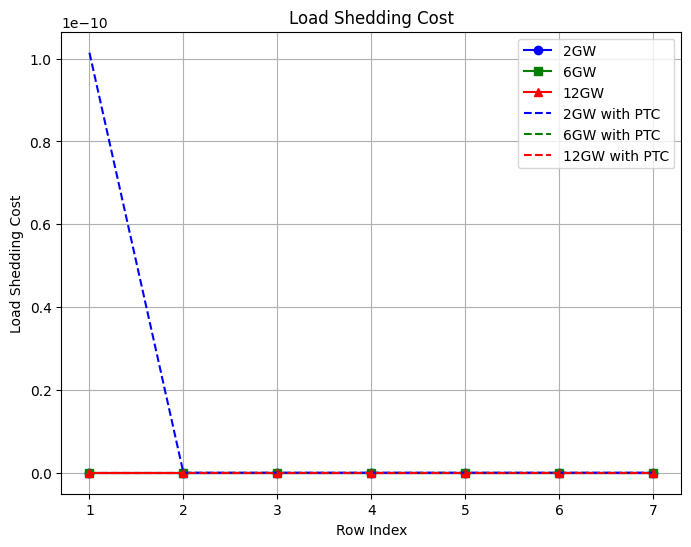

In [222]:
import matplotlib.pyplot as plt
column = 'Load Shedding Cost'

gw2 = pd.read_csv('2GW/costs.csv')
gw6 = pd.read_csv('6GW/costs.csv')
gw12 = pd.read_csv('12GW/costs.csv')

gw2_PTC = pd.read_csv('2GW_PTC/costs.csv')
gw6_PTC = pd.read_csv('6GW_PTC/costs.csv')
gw12_PTC = pd.read_csv('12GW_PTC/costs.csv')

cost1 = gw2[column]
cost2 = gw6[column]
cost3 = gw12[column]

alt_cost1 = gw2_PTC[column]
alt_cost2 = gw6_PTC[column]
alt_cost3 = gw12_PTC[column]

# Create an x-axis (1 through 7)
x = range(1, 8)

# Create the plot
plt.figure(figsize=(8, 6))

# Plot each DataFrame's "Optimal Cost" as a separate line
plt.plot(x, cost1, label='2GW', marker='o', color='blue')
plt.plot(x, cost2, label='6GW', marker='s', color='green')
plt.plot(x, cost3, label='12GW', marker='^', color='red')

# Plot the alternative "Optimal Cost" values with dashed lines
plt.plot(x, alt_cost1, label='2GW with PTC', linestyle='--', color='blue')
plt.plot(x, alt_cost2, label='6GW with PTC', linestyle='--', color='green')
plt.plot(x, alt_cost3, label='12GW with PTC', linestyle='--', color='red')

# Adding labels and title
plt.xlabel('Row Index')
plt.ylabel(column)
plt.title(column)

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

In [298]:
GW = 2

wind_df = pd.DataFrame(columns=['Wind_Generation', 'Hour', 'Day'])
for i in range(1,8):
    wind_temp = pd.read_csv(f'{GW}GW_PTC/wind_gen_day{i}.csv')
    wind_temp['Hour'] = wind_temp.index + 1
    wind_temp['Day'] = 1
    wind_df = pd.concat([wind_df, wind_temp])

wind_df = pd.merge(wind_df, demand_data, 'outer', left_on=['Day', 'Hour'], right_on=['Day', 'Hours'])
wind_df['Wind_Capacity'] = wind_df['WindCF'] * GW * 1000
wind_df['Wind_Curtailed'] = 1- (wind_df['Wind_Generation'] / wind_df['Wind_Capacity'])
wind_df['Hour1'] = ((wind_df['Day'] - 1) * 24) + wind_df['Hours']
wind_df.head()

gw2_PTC_wind = wind_df.copy()

/var/folders/bp/1t28pyb55njgbl4201j77pp80000gn/T/ipykernel_65644/3654567876.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  wind_df = pd.concat([wind_df, wind_temp])


In [300]:
gw2_wind.Hour1.max()

168

In [276]:
gw2_wind.head()

,Wind_Generation,Hour,Day,Hours,WindCF,Demand,Wind_Capacity,Wind_Curtailed
0,1137.050114,1,1,1,0.568525,11452,1137.050114,0.0
1,1137.050114,1,1,1,0.568525,11452,1137.050114,0.0
2,1137.050114,1,1,1,0.568525,11452,1137.050114,0.0
3,1137.050114,1,1,1,0.568525,11452,1137.050114,0.0
4,1137.050114,1,1,1,0.568525,11452,1137.050114,0.0


In [308]:
gw2_PTC_wind.shape

(312, 9)

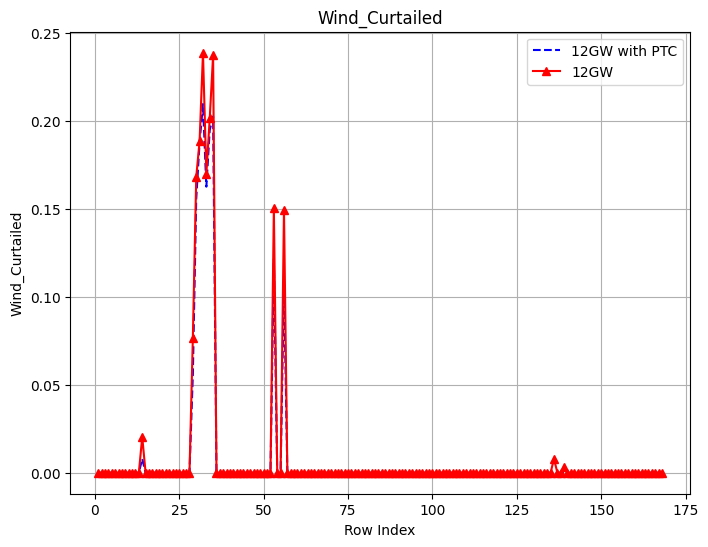

In [316]:
import matplotlib.pyplot as plt
column = 'Wind_Curtailed'

curtailed1 = gw2_wind[column]
curtailed2 = gw6_wind[column]
curtailed3 = gw12_wind[column]

alt_curtailed1 = gw2_PTC_wind[column]
alt_curtailed2 = gw6_PTC_wind[column]
alt_curtailed3 = gw12_PTC_wind[column]

# Create an x-axis (1 through 7)
x = range(1, 313)

# Create the plot
plt.figure(figsize=(8, 6))

# Plot each DataFrame's "Optimal Cost" as a separate line
# plt.plot(x, curtailed1, label='2GW', marker='o', color='blue')
# plt.plot(x, curtailed2, label='6GW', marker='s', color='green')
plt.plot(x, curtailed3, label='12GW', marker='^', color='red')

# Plot the alternative "Optimal Cost" values with dashed lines
# plt.plot(x, alt_curtailed1, label='2GW with PTC', linestyle='--', color='blue')
# plt.plot(x, alt_curtailed2, label='6GW with PTC', linestyle='--', color='green')
plt.plot(x, alt_curtailed3, label='12GW with PTC', linestyle='--', color='blue')

# Adding labels and title
plt.xlabel('Row Index')
plt.ylabel(column)
plt.title(column)

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

In [224]:
demand_data.head()

,Day,Hours,WindCF,Demand
0,1,1,0.568525,11452
1,1,2,0.530670,11009
2,1,3,0.545981,10826
3,1,4,0.423304,10818
4,1,5,0.696597,11118


In [ ]:
for zone, state in zone_to_state.items():
    print(f'Starting {state}')
    # Get state code and daily CO2 limit
    state_code = CO2_Allowances.loc[CO2_Allowances['State'] == state, '2-Letter Code'].values[0]
    daily_limit = zone_daily_co2_limit[state_code]

    # Get generators in this zone
    zone_generators = generator_data[generator_data['Zone \nLocation'].str.contains(zone)]
    zone_indices = zone_generators.index

    print(f"state is {state}. zone indices are {zone_indices}")

    # Calculate total emissions for this state
    total_daily_emissions = 0
    for i in zone_indices:
        # Get the energy type and map to Net_Gen_Emissions
        energy_type = generator_data.loc[i, 'Energy Type']
        if energy_type == "All Other Fuels":
            energy_type = "All energy sources"
        elif energy_type == "Natural Gas and Other Gases":
            energy_type = "Natural gas"
        elif energy_type == "Petroleum Products":
            energy_type = "Petroleum"

        # Retrieve emission factor (short tons per MWh) for the energy type
        emission_factor_row = Net_Gen_Emissions[Net_Gen_Emissions['Energy Type'] == energy_type]
        if emission_factor_row.empty:
            raise ValueError(f"Emission factor not found for energy type: {energy_type}")
        short_tons_per_mwh = emission_factor_row["Short Tons per MWH"].values[0]

        # Add the generator's daily emissions
        daily_generation = np.sum(g.value[i, :])  # Sum over all hours of the day for this generator
        total_daily_emissions += daily_generation * short_tons_per_mwh
        print(f"generator {i} is {energy_type}, doing {short_tons_per_mwh} short tons per MWh")
        print(f"generator {i} daily generation was {daily_generation}")
        print(f"generator {i} total contribution to CO2 was {daily_generation * short_tons_per_mwh}")

# Plotting


Text(0.5, 1.0, 'Heatmap of Generators On (Blue) and Off (Red) - 30000MW Scenario')

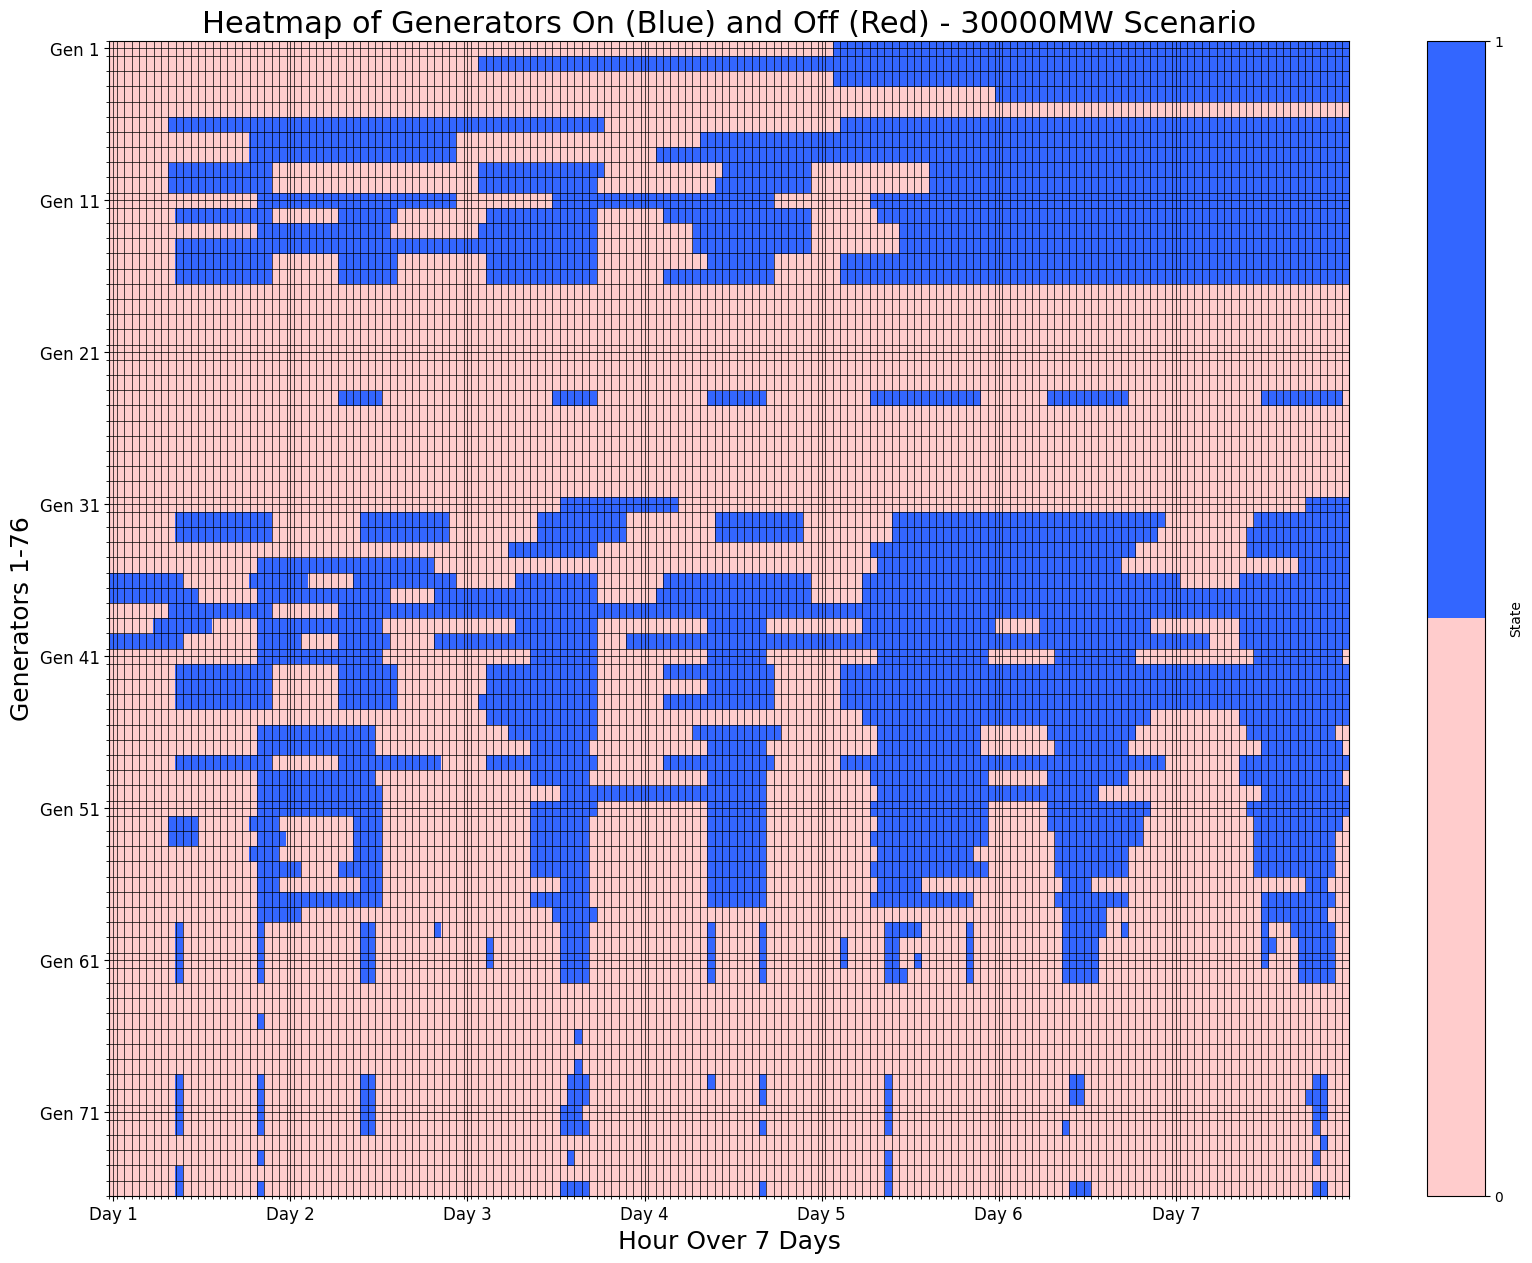

In [7]:
#Heatmap Plotting

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

binary_cmap = ListedColormap(["#FFCCCC", "#3366FF"])  # Off: Light Red, On: Blue

prefix = "30000MW"

file_names = [
    f"{prefix}/u_day1.csv",
    f"{prefix}/u_day2.csv",
    f"{prefix}/u_day3.csv",
    f"{prefix}/u_day4.csv",
    f"{prefix}/u_day5.csv",
    f"{prefix}/u_day6.csv",
    f"{prefix}/u_day7.csv",
]

data_frames = [pd.read_csv(file) for file in file_names]

combined_data = pd.concat(data_frames, axis=1)

plt.figure(figsize=(20, 15))
plt.imshow(combined_data, aspect="auto", cmap=binary_cmap, interpolation="none")
plt.colorbar(ticks=[0, 1], label="State", format='%d')  # Discrete legend (0: Off, 1: On)

# Add gridlines for better visualization of each box
plt.grid(which="major", color="black", linestyle="-", linewidth=0.5)

# Set x-axis and y-axis tick labels
plt.xticks(ticks=np.arange(0, combined_data.shape[1], 24), 
           labels=[f"Day {i+1}" for i in range(7)], fontsize=12)
plt.yticks(ticks=np.arange(0, combined_data.shape[0], 10), 
           labels=[f"Gen {i+1}" for i in range(0, 76, 10)], fontsize=12)

# Ensure gridlines are visible
plt.gca().set_xticks(np.arange(-0.5, combined_data.shape[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-0.5, combined_data.shape[0], 1), minor=True)
plt.grid(which="minor", color="black", linestyle="-", linewidth=0.5)

# Set labels and title
plt.xlabel("Hour Over 7 Days", fontsize=18)
plt.ylabel("Generators 1-76", fontsize=18)
plt.title(f"Heatmap of Generators On (Blue) and Off (Red) - {prefix} Scenario", fontsize=22)

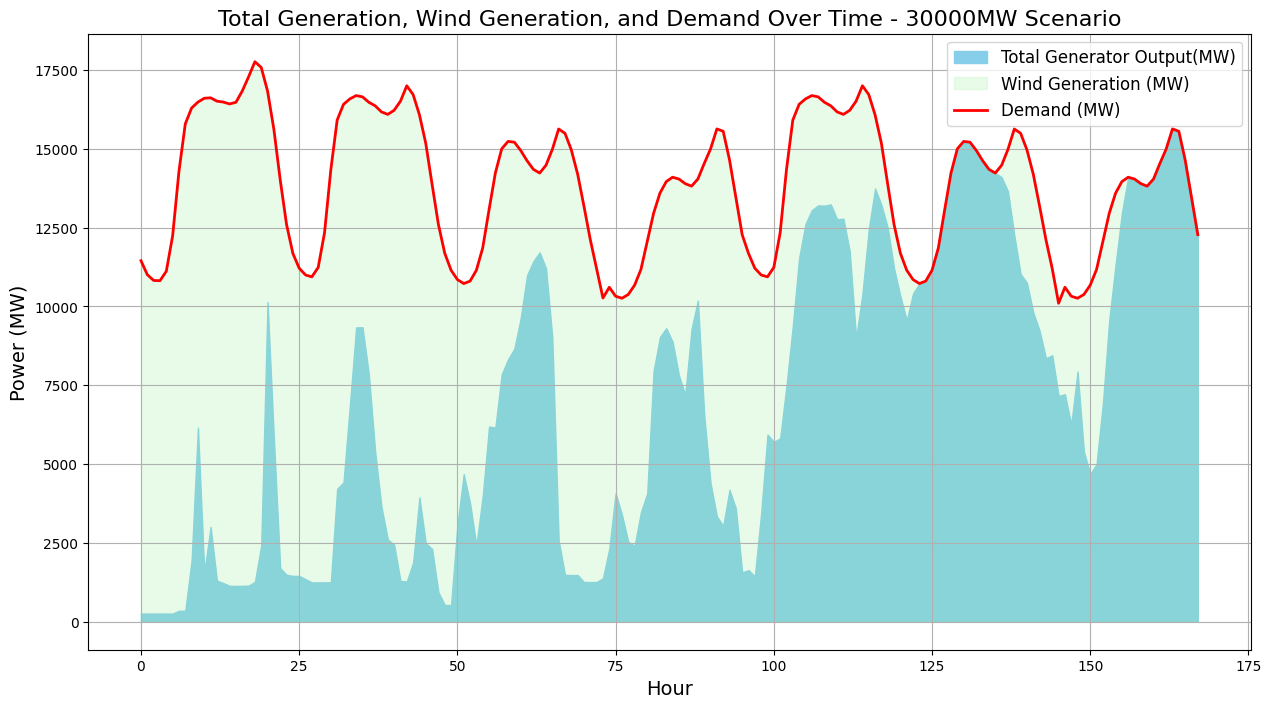

In [8]:
# Demand vs gen plots

prefix = "30000MW"

gen_files = [
    f"{prefix}/gen_day1.csv",
    f"{prefix}/gen_day2.csv",
    f"{prefix}/gen_day3.csv",
    f"{prefix}/gen_day4.csv",
    f"{prefix}/gen_day5.csv",
    f"{prefix}/gen_day6.csv",
    f"{prefix}/gen_day7.csv",
]

# Aggregate generator data (sum across rows for each hour)
gen_data = [pd.read_csv(file).sum(axis=0) for file in gen_files]

# Concatenate hourly sums into a single DataFrame with 'hour' and 'total_gen'
total_gen_df = pd.DataFrame({
    "hour": list(range(0, 24)) * 7,
    "total_gen": pd.concat(gen_data, axis=0).reset_index(drop=True)
})

total_gen_df["hour"] = range(len(total_gen_df))

# Output the result to a CSV file
output_file1 = f"{prefix}/total_gen_per_hour.csv"
total_gen_df.to_csv(output_file1, index=False)

wind_files = [
    f"{prefix}/wind_gen_day1.csv",
    f"{prefix}/wind_gen_day2.csv",
    f"{prefix}/wind_gen_day3.csv",
    f"{prefix}/wind_gen_day4.csv",
    f"{prefix}/wind_gen_day5.csv",
    f"{prefix}/wind_gen_day6.csv",
    f"{prefix}/wind_gen_day7.csv",
]

# Aggregate wind generation data (concatenate 'Wind_Generation' columns)
wind_data = [pd.read_csv(file)["Wind_Generation"] for file in wind_files]
wind_gen_df = pd.concat(wind_data, axis=0).reset_index(drop=True)

# Create a DataFrame with hour and wind generation
wind_gen_output = pd.DataFrame({
    "hour": list(range(0, 24)) * 7,  # 24 hours for 7 days
    "wind_gen": wind_gen_df
})

wind_gen_output["hour"] = range(len(wind_gen_output))

# Output the result to a CSV file
wind_output_file = f"{prefix}/wind_gen_per_hour.csv"
wind_gen_output.to_csv(wind_output_file, index=False)

total_gen_data = pd.read_csv(f"{prefix}/total_gen_per_hour.csv")
wind_gen_data = pd.read_csv(f"{prefix}/wind_gen_per_hour.csv")
wind_and_demand_data = pd.read_csv(f"{prefix}/wind_and_demand.csv")

# Extract relevant columns
hour = total_gen_data["hour"]
total_gen = total_gen_data["total_gen"]
wind_gen = wind_gen_data["wind_gen"]
demand = wind_and_demand_data["Demand"]

hour_array = np.array(hour)
total_gen_array = np.array(total_gen)
wind_gen_array = np.array(wind_gen)
demand_array = np.array(demand)

plt.figure(figsize=(15, 8))
plt.fill_between(hour_array, total_gen_array, color='skyblue', label='Total Generator Output(MW)', alpha=1)
plt.fill_between(hour_array, total_gen_array + wind_gen_array, color='lightgreen', label='Wind Generation (MW)', alpha=.2)
plt.plot(hour_array, demand_array, color='red', label='Demand (MW)', linewidth=2)

plt.xlabel("Hour", fontsize=14)
plt.ylabel("Power (MW)", fontsize=14)
plt.title(f"Total Generation, Wind Generation, and Demand Over Time - {prefix} Scenario", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()


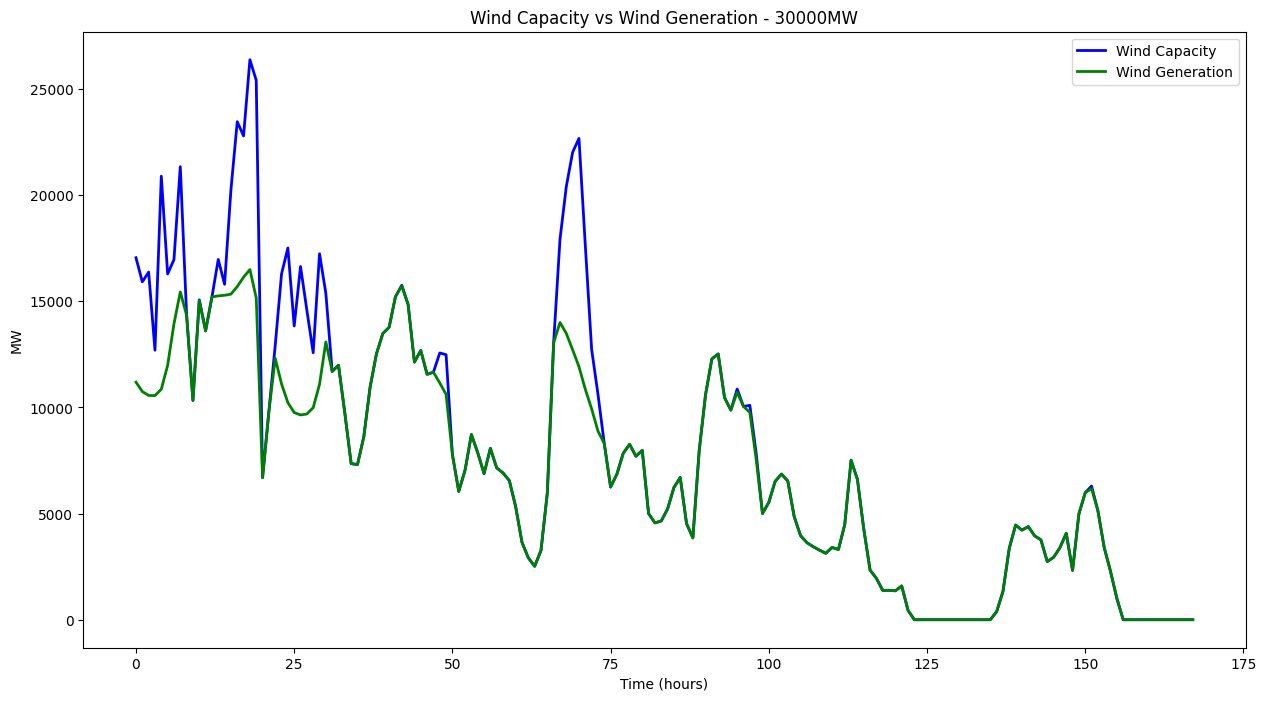

In [9]:
import numpy as np

prefix = "30000MW"
scenario_mw = 30000 #MW

wind_and_demand = pd.read_csv(f"{prefix}/wind_and_demand.csv")
wind_gen_per_hour = pd.read_csv(f"{prefix}/wind_gen_per_hour.csv")

# Add a new column to wind_and_demand.csv
wind_and_demand['WindCapacity'] = scenario_mw * wind_and_demand['WindCF']

# Plot the new column and the wind_gen column
plt.figure(figsize=(15, 8))

# Plot WindCapacity from wind_and_demand
plt.plot(wind_and_demand.index, wind_and_demand['WindCapacity'], label='Wind Capacity', color='blue', linewidth=2)

# Plot wind_gen from wind_gen_per_hour
plt.plot(wind_gen_per_hour.index, wind_gen_per_hour['wind_gen'], label='Wind Generation', color='green', linewidth=2)

# Add titles and labels
plt.title(f"Wind Capacity vs Wind Generation - {prefix}")
plt.xlabel('Time (hours)')
plt.ylabel('MW')
plt.legend()

# Show the plot
plt.show()

## PROFIT CALC

In [ ]:
import pandas as pd
import numpy as np

def load_data(file_path):
    return pd.read_csv(file_path)

prefix = '12GW_RGGI'
costs_array = load_data(f'{prefix}/costs.csv')
marginal_prices_by_hour = load_data(f'{prefix}/marginal_prices.csv')
demand_data = load_data('wind_and_demand.csv')
# day1gen = load_data(f'{prefix}/gen_day1.csv')
# day2gen = load_data(f'{prefix}/gen_day2.csv')
# day3gen = load_data(f'{prefix}/gen_day3.csv')
# day4gen = load_data(f'{prefix}/gen_day4.csv')
# day5gen = load_data(f'{prefix}/gen_day5.csv')
# day6gen = load_data(f'{prefix}/gen_day6.csv')
# day7gen = load_data(f'{prefix}/gen_day7.csv')
# # Assuming day1gen to day7gen are DataFrames in your environment
# day_gens = [day1gen, day2gen, day3gen, day4gen, day5gen, day6gen, day7gen]
# # Rename columns for each day
# for i, df in enumerate(day_gens, start=1):
#     df.columns = [f"day{i}_hour_{col}" for col in df.columns]
# # Merge all DataFrames horizontally
# merged_df = pd.concat(day_gens, axis=1)


# Loop through days and hours
for day in range(1, 8):  # Days 1 to 7
    for hour in range(24):  # Hours 0 to 23
        # Get the marginal price for this day and hour
        marginal_price = marginal_prices_by_hour.iloc[hour, day - 1]  # `day - 1` for 0-based indexing

        # Find the corresponding row in demand_data
        matching_row = demand_data[(demand_data['Day'] == day) & (demand_data['Hours'] == hour + 1)]  # `hour + 1` since Hours in demand_data is 1-based
        if not matching_row.empty:
            # Extract the demand value
            demand_value = matching_row['Demand'].values[0]

            # Calculate the value and store it
            result_array[hour, day - 1] = float(marginal_price * demand_value)
        else:
            # Handle case where no matching row exists (optional)
            result_array[hour, day - 1] = 0  # Default to 0 or another appropriate value

# Convert result_array to a DataFrame for better readability
result_df = pd.DataFrame(
    result_array,
    columns=[f"Day{day}" for day in range(1, 8)],
    index=[f"Hour{hour}" for hour in range(24)]
)
result_df
total_sum_revenue = result_df.values.sum()
costs_array_sum = costs_array['Optimal Cost'].sum()
profit = total_sum_revenue - costs_array_sum
print(total_sum_revenue, costs_array_sum, profit)
